In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro, probplot
from sklearn import preprocessing
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Adapts size of the graphs.
plt.rcParams["figure.figsize"] = (30,20)

In [3]:
# Parser
def read_unirep(file_path):
    """
    Parse a Unirep file.
    """
    data_matrix = []
    with open(file_path) as fp:
        data = fp.readlines()
    for i, line in enumerate(data):
        if line[0] == '>':
            data_matrix.append(np.array(
                data[i + 1].strip().split(sep=' '),
                dtype=np.float64))
    return np.array(data_matrix)

In [4]:
# Plots probability plots side by side
def prob_plot(dataset):
    fig, axs = plt.subplots(8, 8)
    for j in range(1, 65):
        plt.subplot(8, 8, j)
        probplot(dataset[j-1], plot=plt)
        plt.title("feature {}".format(j))
        plt.xlabel("")
        plt.ylabel("")
    plt.tight_layout()
    plt.show()

In [5]:
# Plots histograms side by side
def hist_plot(dataset):
    fig, axs = plt.subplots(8, 8)
    for j in range(1, 65):
        plt.subplot(8, 8, j)
        plt.hist(dataset[j-1], bins=20)
        plt.title("feature {}".format(j))
        plt.xlabel("")
        plt.ylabel("")
    plt.tight_layout()
    plt.show()

In [8]:
# Imports unirep data.
raw_cyt = read_unirep("cytoxplasmUniRef50(1).unirep")
raw_peri = read_unirep("periplasm_without_sp.unirep")
# Shuffle unirep sets
np.random.shuffle(raw_cyt)
np.random.shuffle(raw_peri)
# Selectes 3000 first elements of each shuffled set (= random selection).
all_raw = np.concatenate((raw_cyt[0:3000], raw_peri[0:3000]))

In [9]:
print(len(raw_cyt))
print(len(raw_peri))
print(len(all_raw))

16408
3457
6000


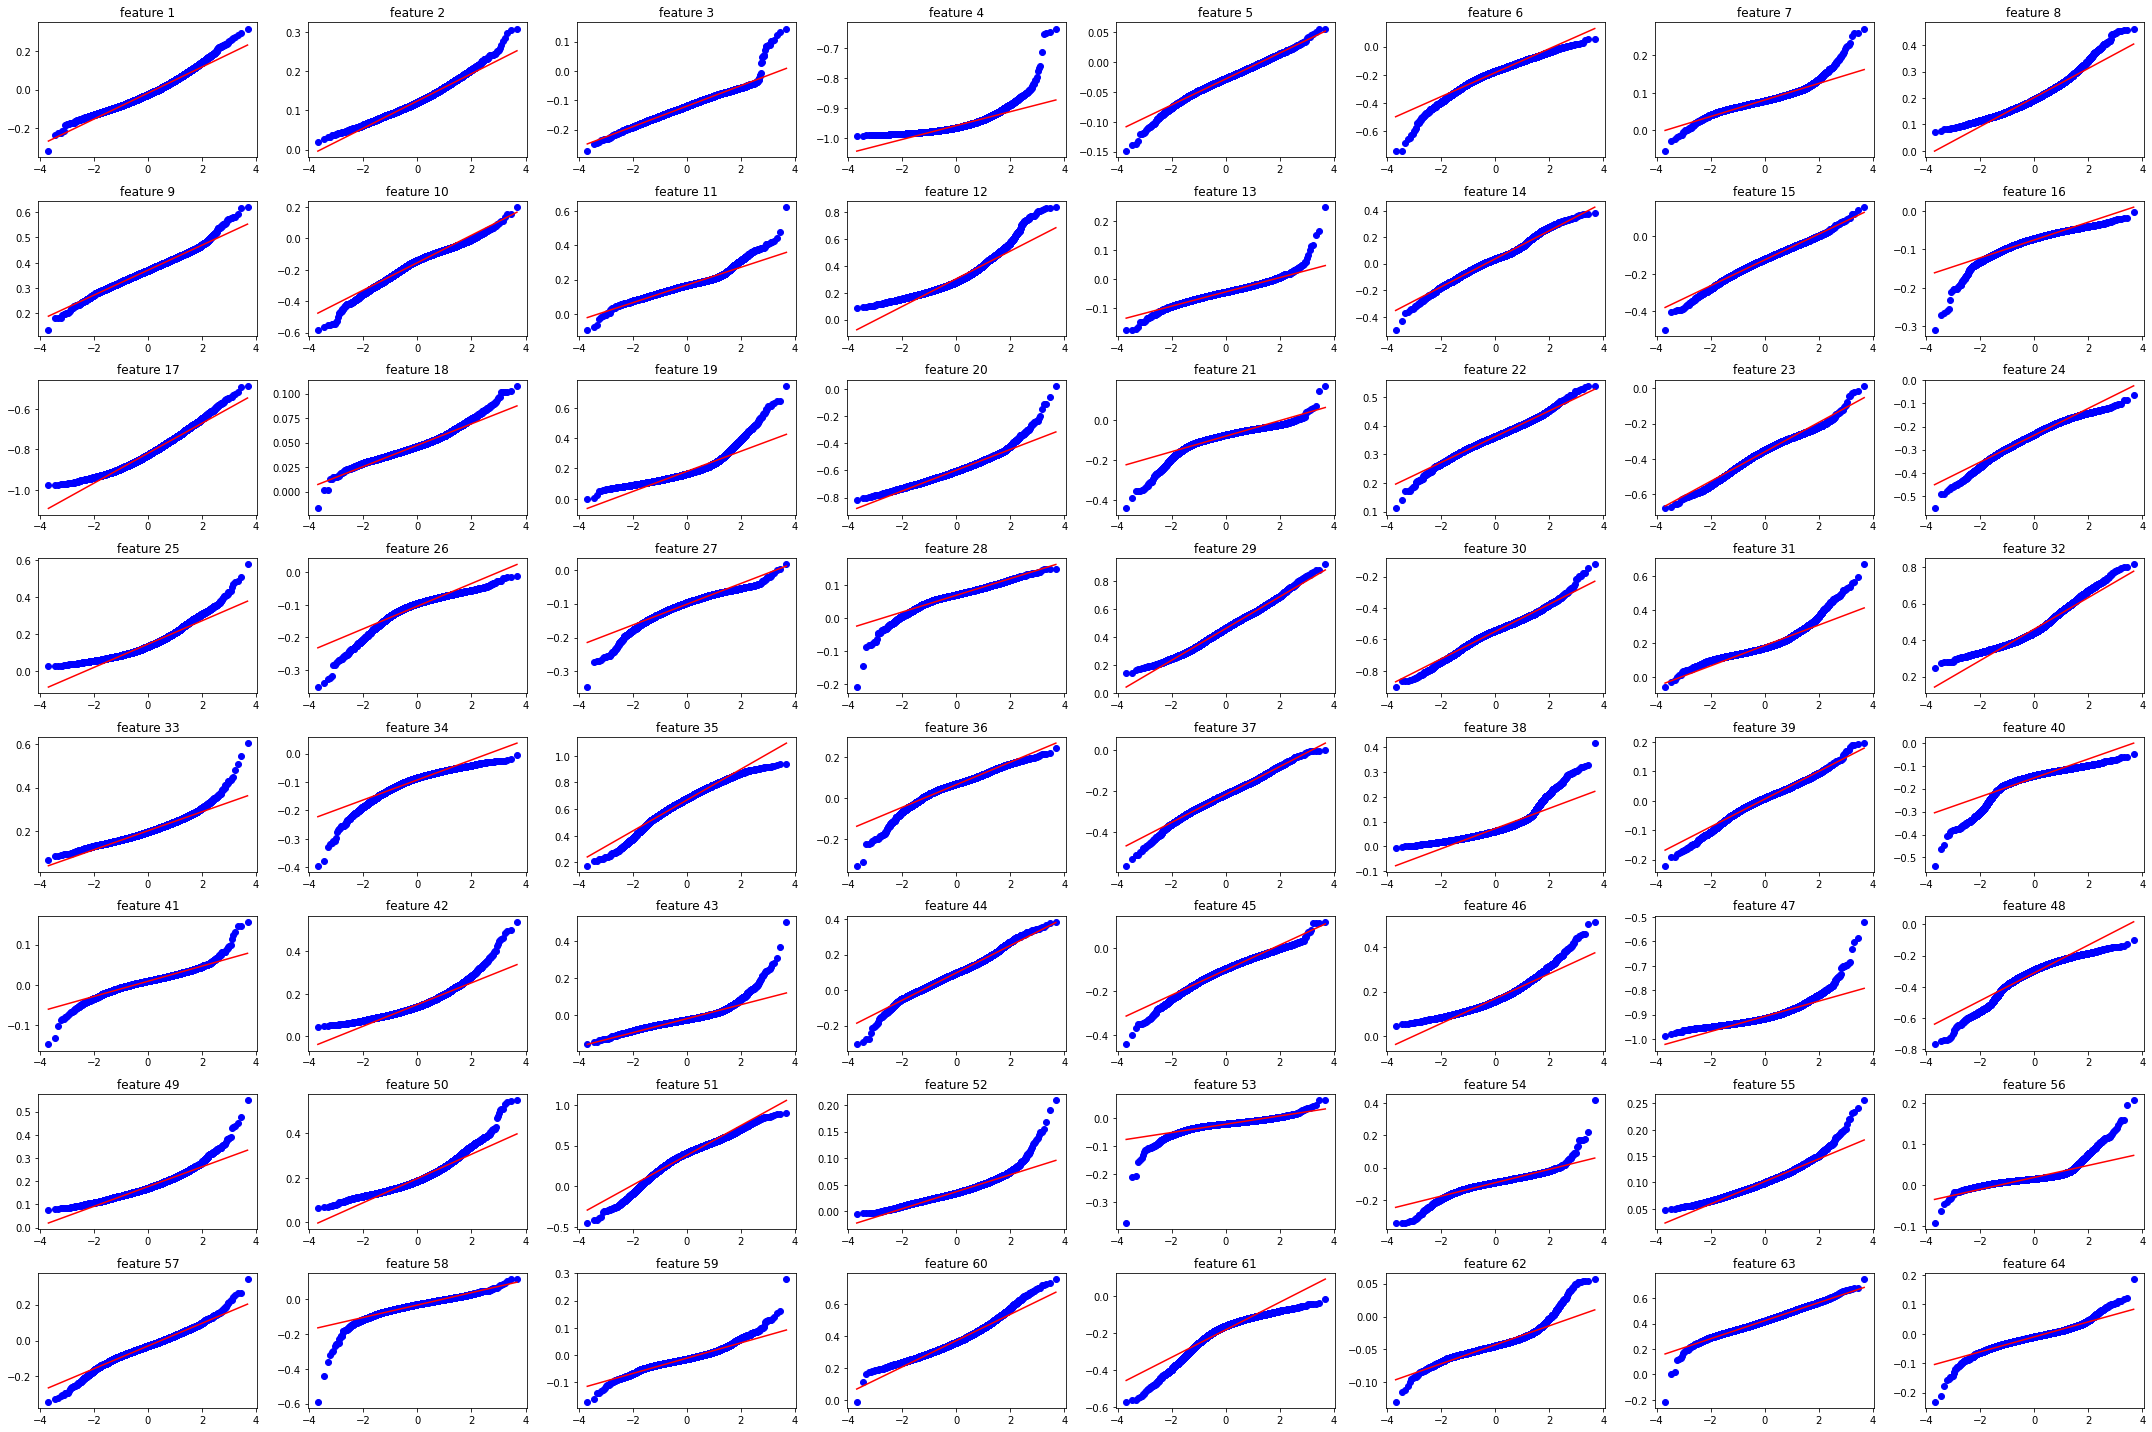

In [10]:
# Probability plot for normality check.
prob_plot(all_raw.T)

These are probability plot (similar to QQ plots). When the data are normally distributed, the blue curve fits the linear diagonal. Here, we can see that most features doesn't follow a normal distribution. We will try to pre-process the data to get closer to the normal distribution. 

Note: Shapiro-wilk doesn't work, there are too many samples, the test becomes too sensitive and doesn't declares anything as normally distributed.

In [11]:
# Log transform to try to normalize.
log_transform = np.log(all_raw.T + 1)

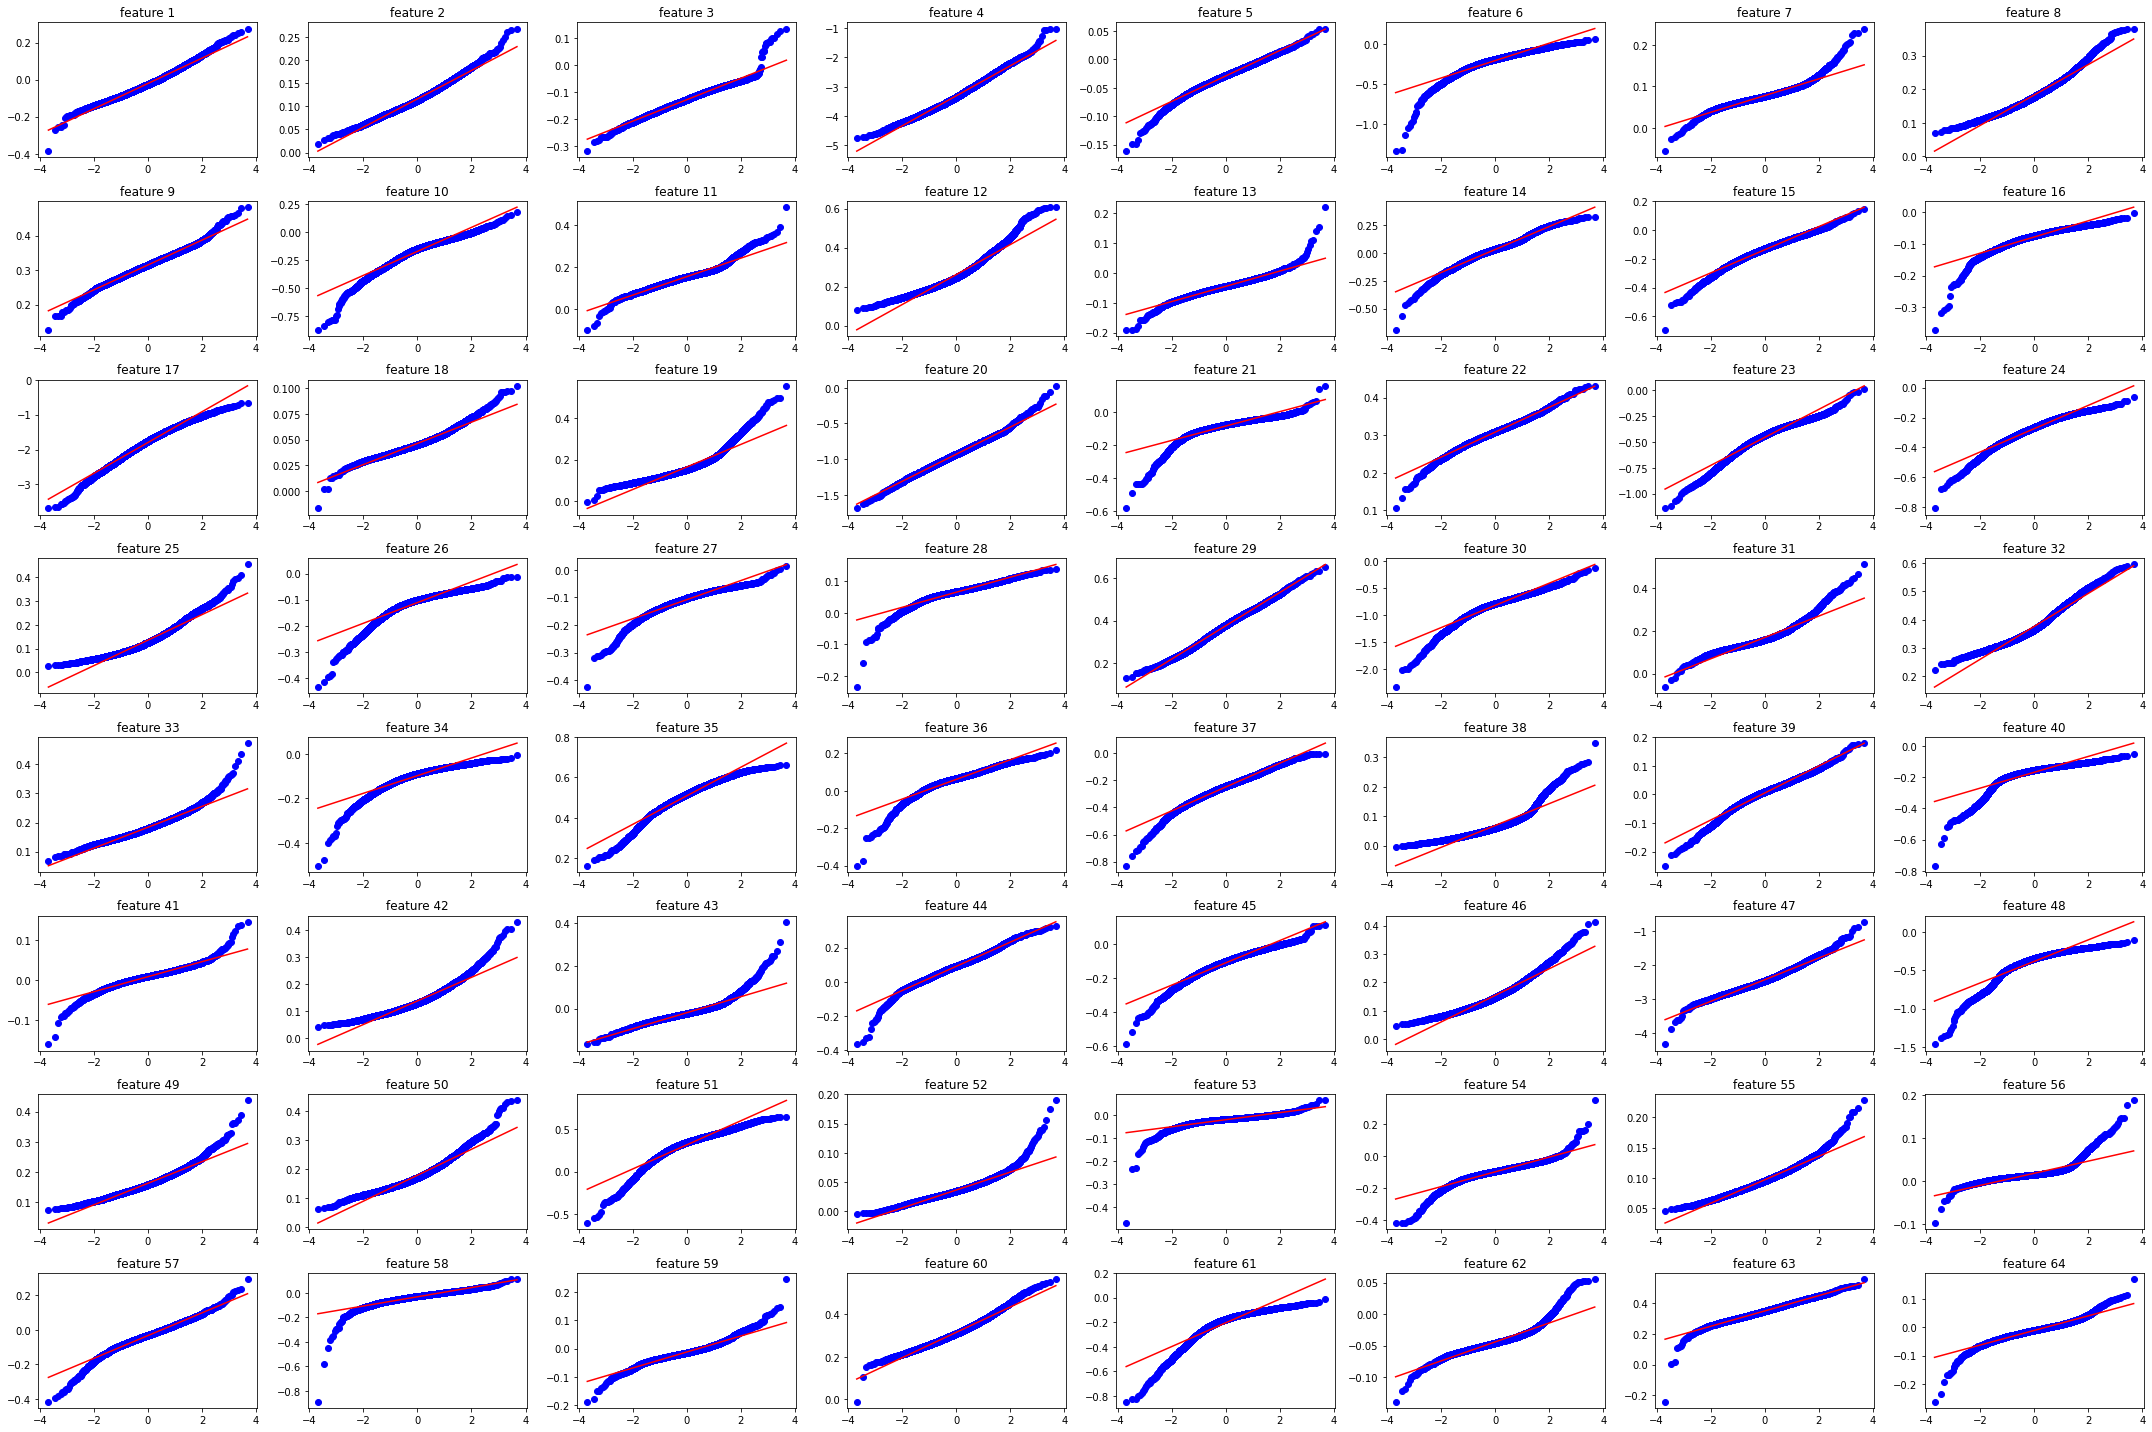

In [12]:
# Probability plot for normality check.
prob_plot(log_transform)

Log transform gives better results for some features, but not for all. Let's try simple scaling (mean 0, std 1)

In [13]:
# Data scaling, mean = 0, std = 1.
scaled_transfrom = preprocessing.scale(all_raw, axis=0)

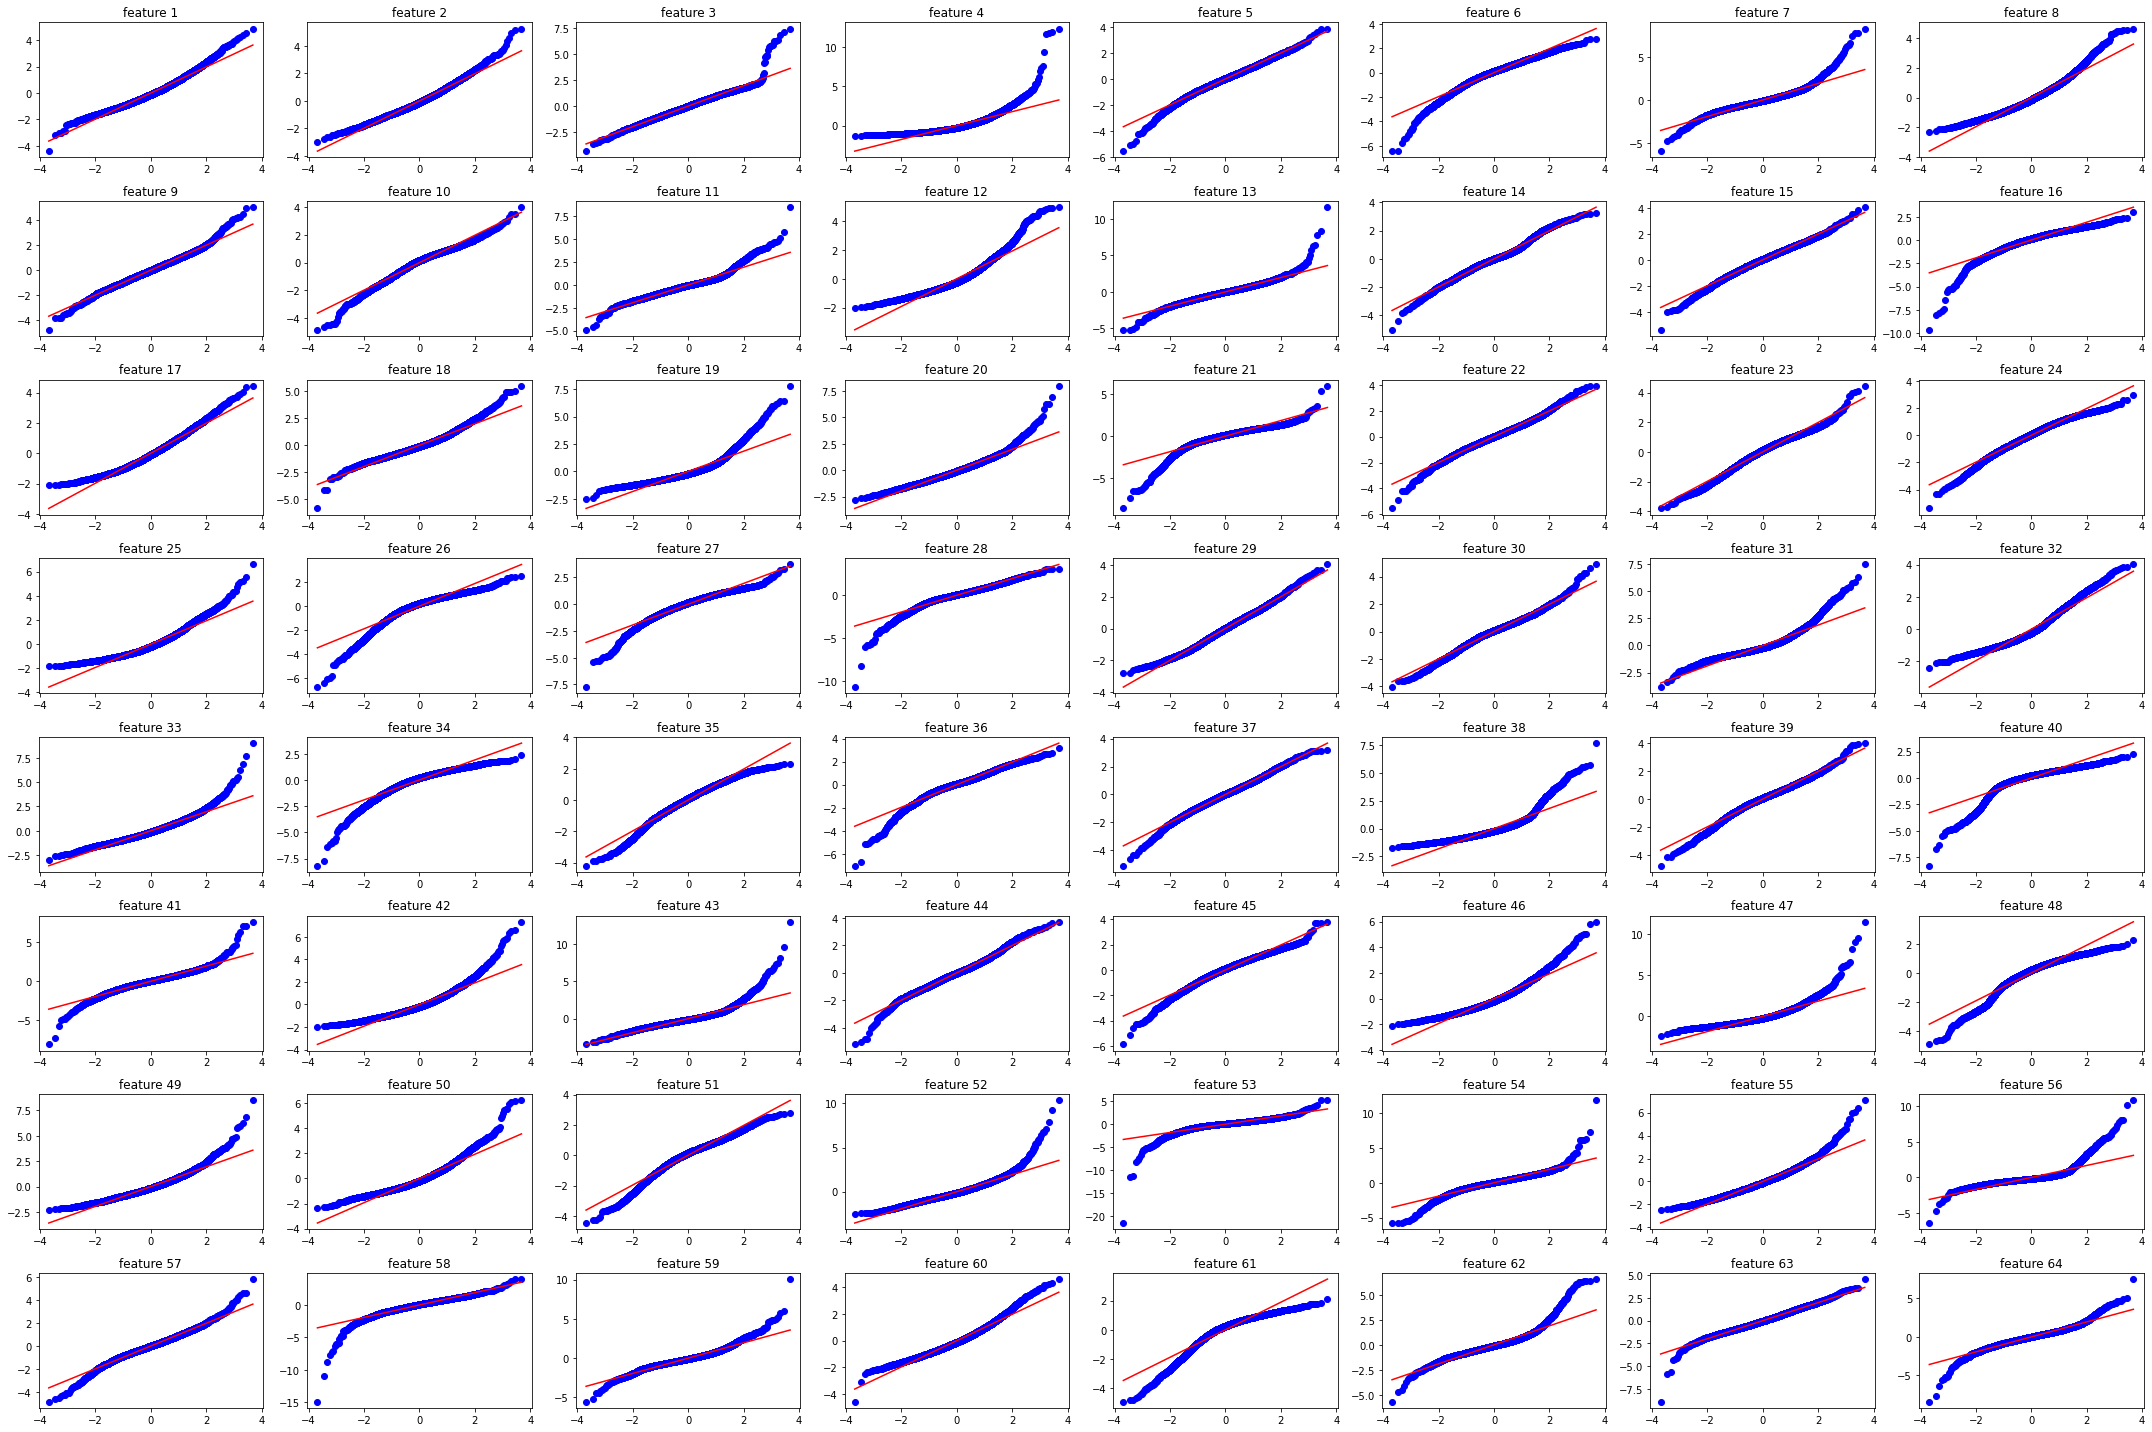

In [14]:
# Probability plot for normality check.
prob_plot(scaled_transfrom.T)

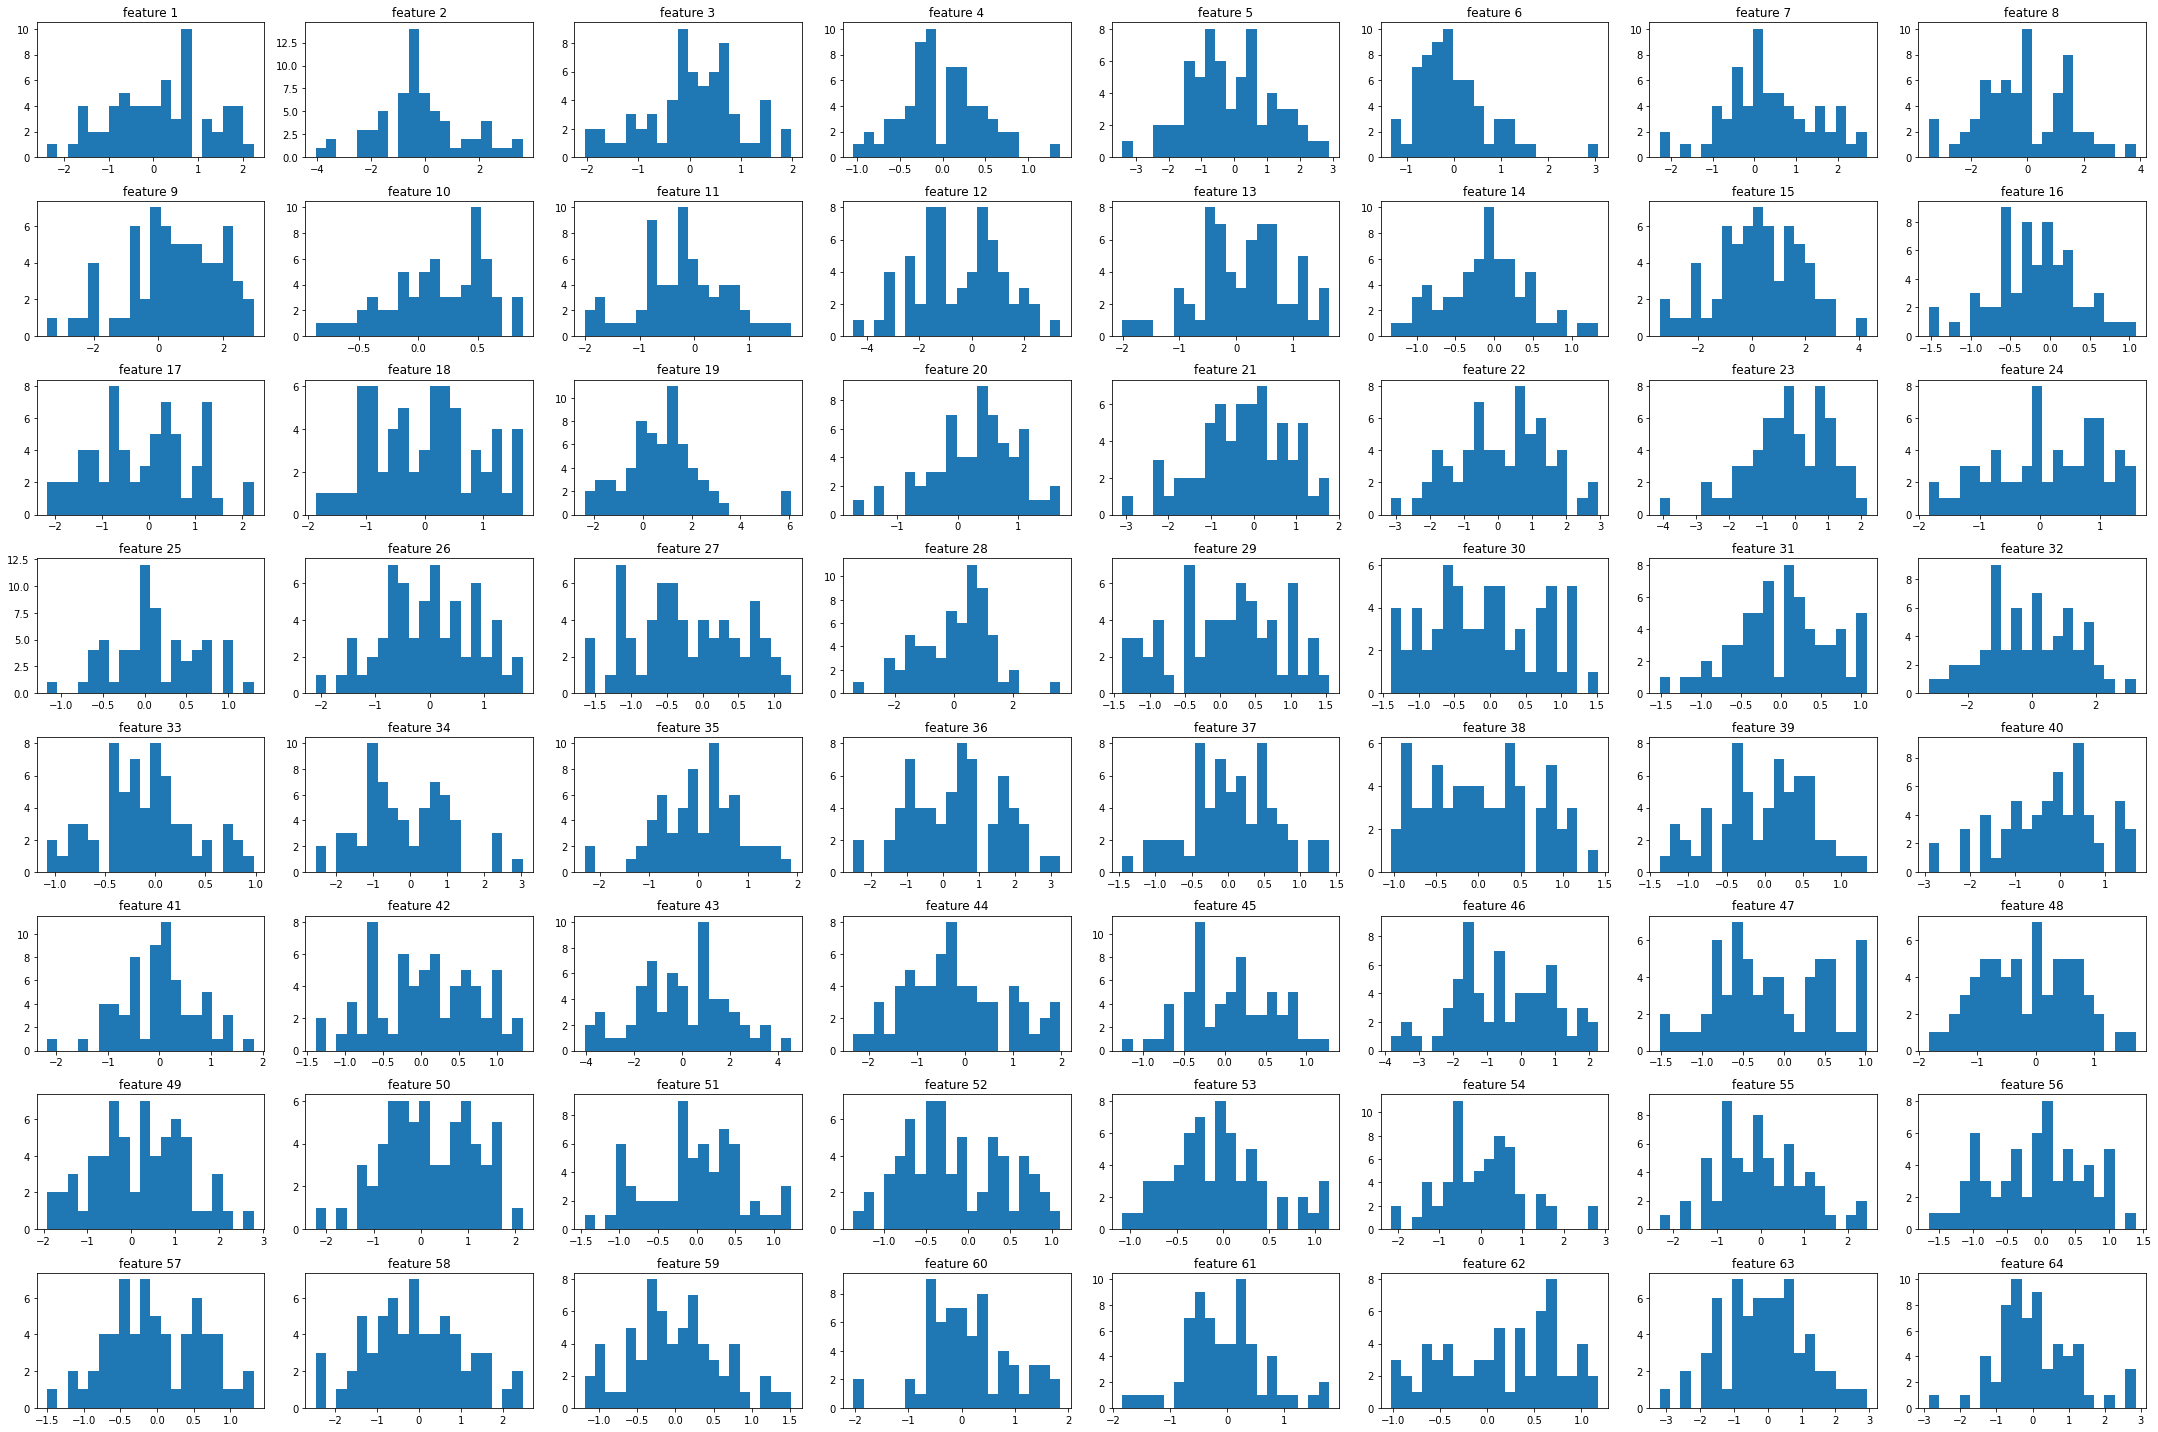

In [15]:
# Histograms
hist_plot(scaled_transfrom)

In [16]:
# Gives value 1 to cytoplasmic proteins, 0 to others.
labels = np.zeros(len(scaled_transfrom))
labels[0:3000] = 1

In [17]:
labels

array([1., 1., 1., ..., 0., 0., 0.])

In [18]:
# Shuffle data and creates mixed dataset.
np.random.shuffle(raw_cyt)
np.random.shuffle(raw_peri)
all_raw = np.concatenate((raw_cyt[0:3000], raw_peri[0:3000]))
# Data scaling, mean = 0, std = 1.
scaled_transfrom = preprocessing.scale(all_raw, axis=0)
# Generate PCA object.
pca = PCA()
# Fit PCA to the data.
pca.fit(scaled_transfrom)
# print(pca.explained_variance_ratio_)
pca_data = pca.fit_transform(scaled_transfrom)

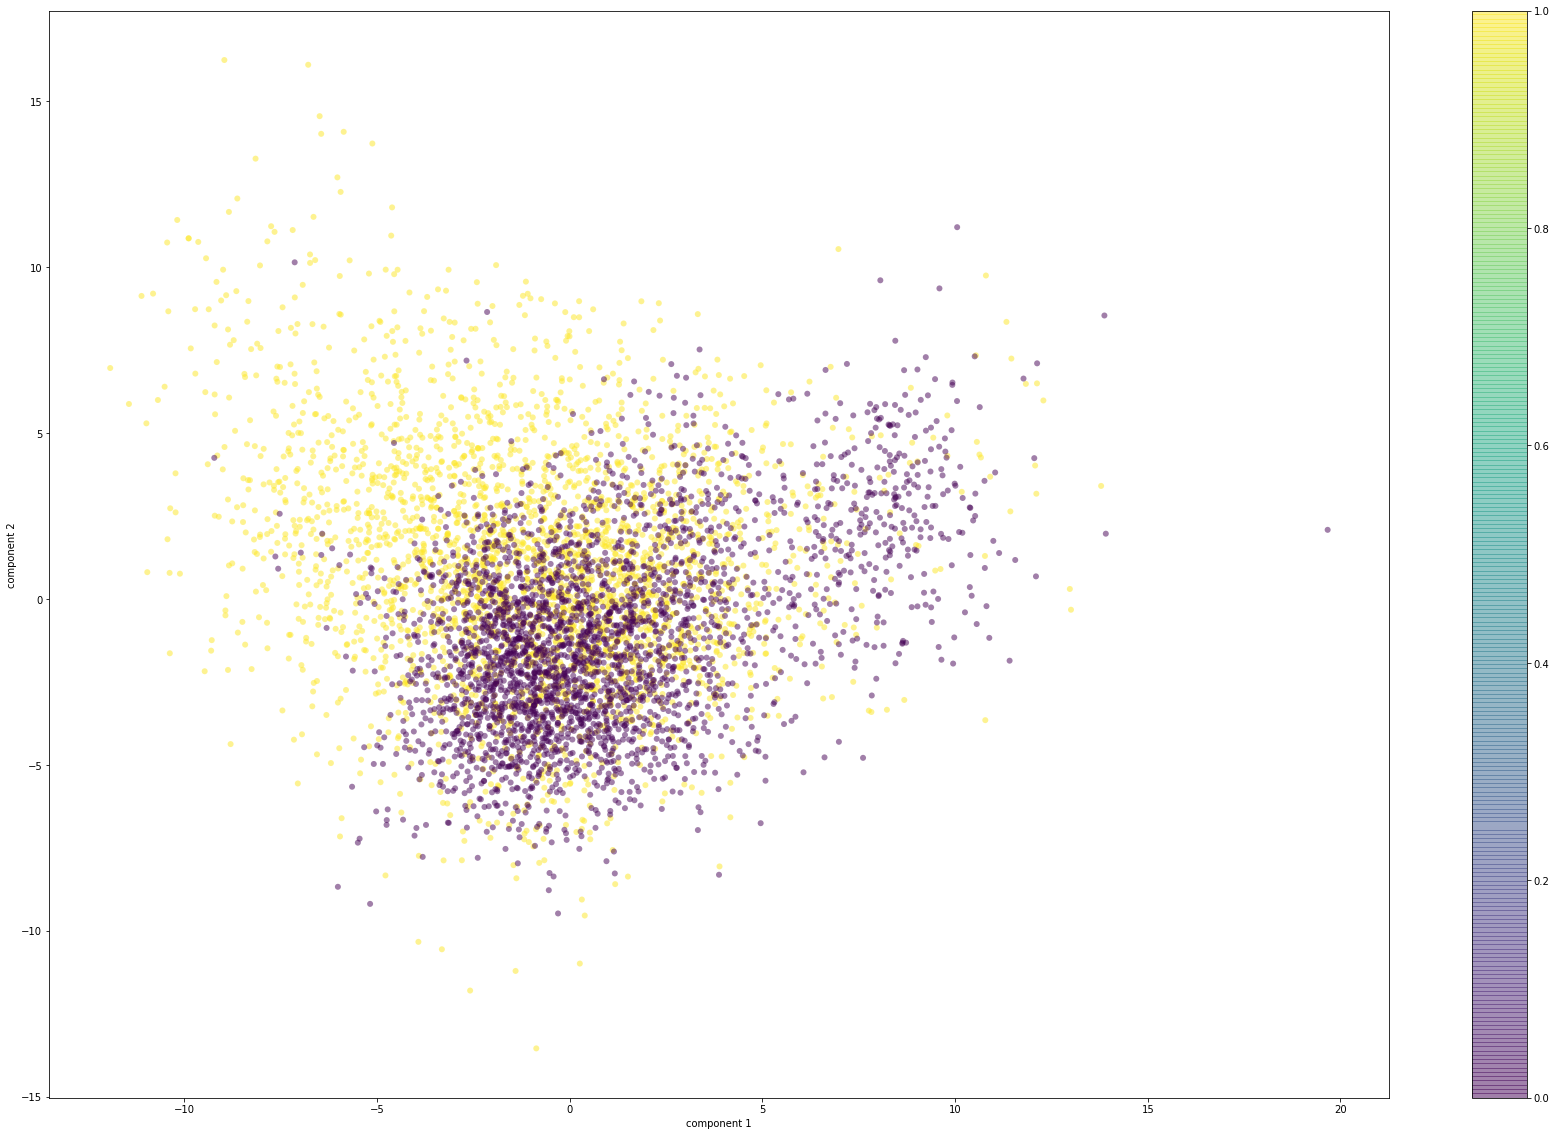

In [19]:
# Plot the PCA.
plt.scatter(pca_data[:, 0], pca_data[:, 1],
            c=labels, edgecolor='none', alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()

PCA plot. We can see two 'spots', but there is a large overlap between the two.

Text(0.5, 0, 'z axis')

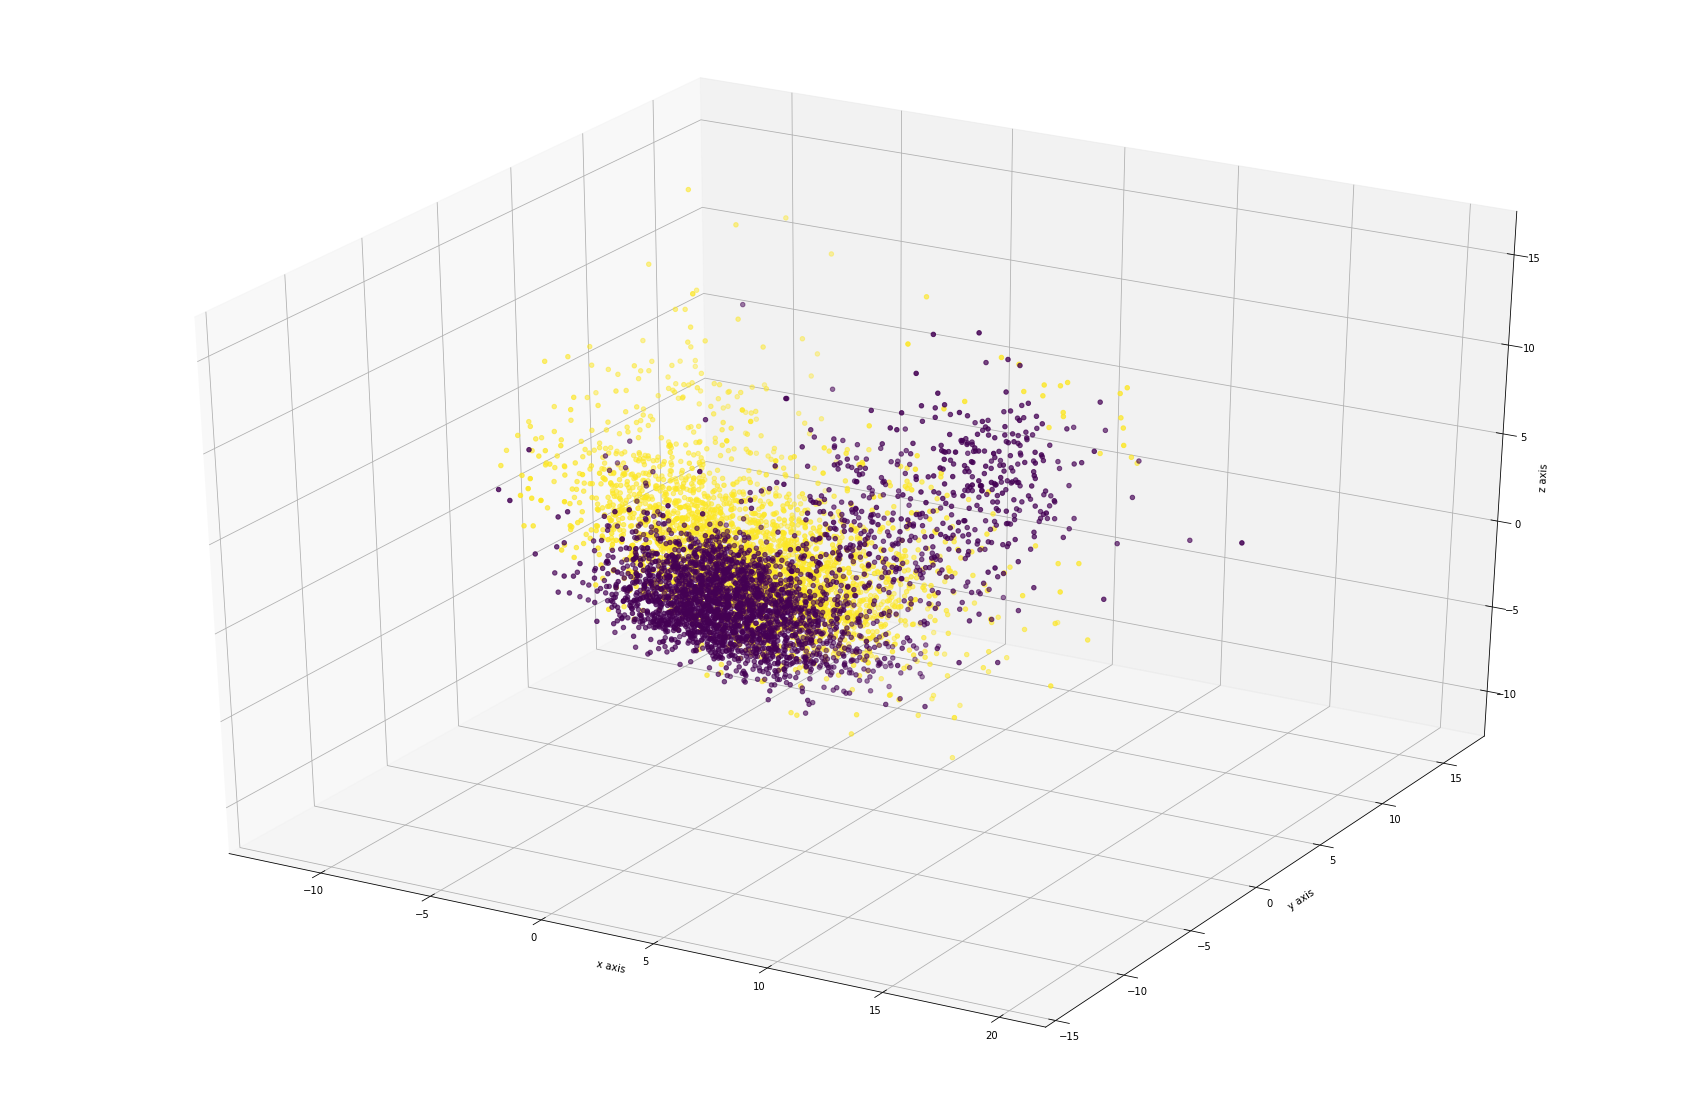

In [20]:
fig=plt.figure()
ax=fig.add_subplot(111, projection='3d')
xs,ys,zs=pca_data[:, 0], pca_data[:, 1], pca_data[:, 2]
ax.scatter(xs,ys,zs, c=labels)
ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')

Using the third principal component, we get a good separation.

100%|██████████| 50000/50000 [02:12<00:00, 377.29it/s]


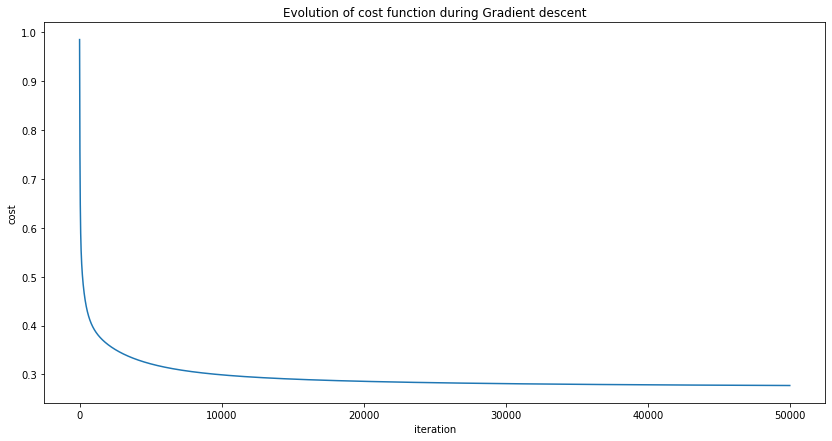

/home/jan/.local/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


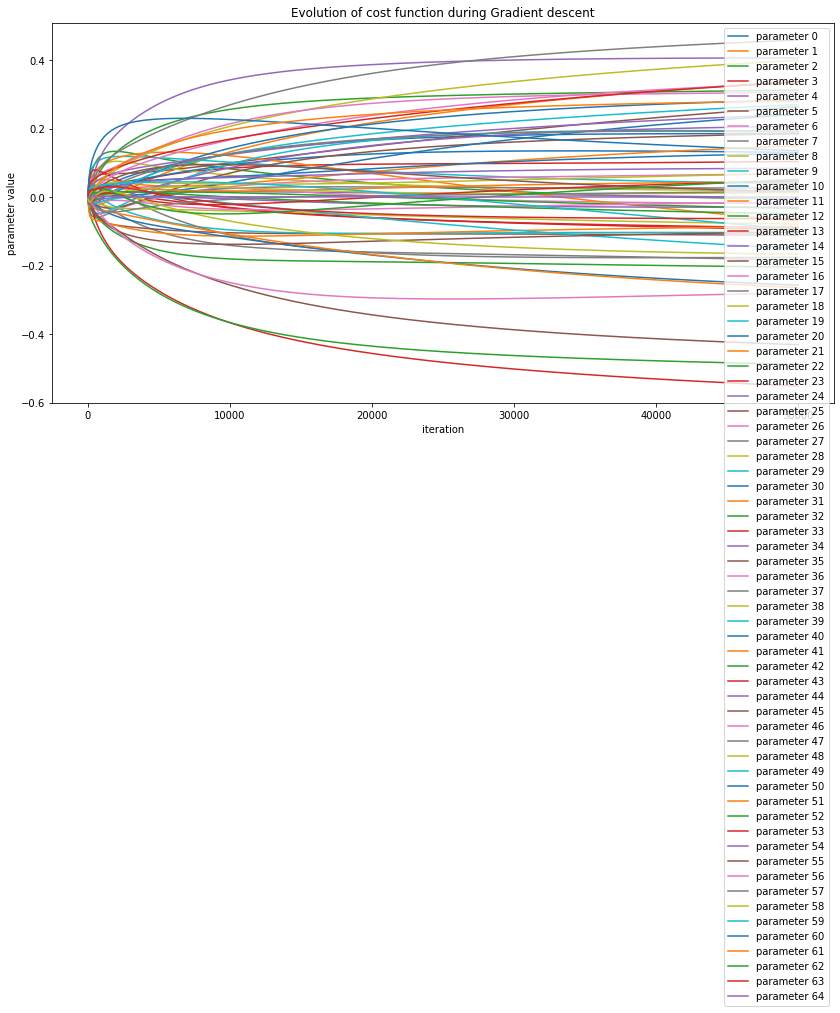

0.9455555555555556

In [25]:
from sklearn.model_selection import train_test_split
import LinearRegression
import imp
imp.reload(LinearRegression)

X = scaled_transfrom
y = labels[:,np.newaxis]
y[y==0]=-1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=2)


LR = LinearRegression.LinearRegression(X_train,y_train)
params, paramsEvo, costEvo = LR.gradientDescent(iterations=int(5e4),learningRate=1e-3)
LR.plotGradientDescent()

LR.predictTestSet(X_test,y_test)